# Wine Enthusiast Dataset

1.	Which vineyard produces the best wine?
2.	If you had to pick 3 wines to recommend using only this data, which would you pick?
3.	Which of the factors (price, country, variety, taster) are most important in determining the overall score of a wine?
4.	Lastly, if I typically enjoy a wine which is “dry” and has “citrus” flavours, which variety of wine should I try?  


In [135]:
# Importing Relevant Libraries

# Standard Data analysis libraries

import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
from PIL import Image
import random
import openpyxl
from collections import Counter

import seaborn as sns
from scipy.stats import skew, kurtosis

# Sklearn for machine learning

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error

#from wordcloud import WordCloud

#NLTK for textual analysis

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
import string

**Loading file**

In [2]:
handle = "wine_enthusiast_dataset.csv"
wine_df = pd.read_csv(handle)

### Data Preparation

**Fixing string coding issues**

In [3]:
def recode(string):
    try:
        if isinstance(string, str):
            return string.encode("Windows-1252").decode("utf-8")
        else:
            return string
    except Exception:
        return string
        

    
wine_df["variety"] = wine_df["variety"].apply(lambda x:recode(x))
wine_df["taster_name"] = wine_df["taster_name"].apply(lambda x:recode(x))
wine_df["winery"] = wine_df["winery"].apply(lambda x:recode(x))
wine_df["title"] = wine_df["title"].apply(lambda x:recode(x))
wine_df["description"] = wine_df["description"].apply(lambda x:recode(x))

**Quick exploratory commands**

In [4]:
print(wine_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130147 entries, 0 to 130146
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   wine_id                130147 non-null  int64  
 1   country                130084 non-null  object 
 2   description            130147 non-null  object 
 3   designation            92682 non-null   object 
 4   points                 130147 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               130084 non-null  object 
 7   region_1               108900 non-null  object 
 8   region_2               50687 non-null   object 
 9   taster_name            103903 non-null  object 
 10  taster_twitter_handle  98934 non-null   object 
 11  title                  130147 non-null  object 
 12  variety                130146 non-null  object 
 13  winery                 130147 non-null  object 
dtypes: float64(1), int64(2), object(11)


In [5]:
print(wine_df.describe())

             wine_id         points          price
count  130147.000000  130147.000000  120975.000000
mean    65073.000000      88.506174      35.363389
std     37570.347079       3.872797      41.022218
min         0.000000       0.000000       4.000000
25%     32536.500000      86.000000      17.000000
50%     65073.000000      88.000000      25.000000
75%     97609.500000      91.000000      42.000000
max    130146.000000     150.000000    3300.000000


We can see that some wines are rated above 100 or below 80. However, according to: 
https://www.wineenthusiast.com/ratings/

The highest possible rating is 100 and the lowest possible is 80.

There are erroneous values, to be removed.

In [6]:
# all these values are erroneous
print(wine_df[wine_df["points"] > 100].head())
print(wine_df[wine_df["points"] < 80].head())

      wine_id country description designation  points  price province  \
213    130026       ¢           ¢           ¢     150    NaN        ¢   
4210   130118       ¢           ¢           ¢     150    NaN        ¢   
4689   130060       ¢           ¢           ¢     150    NaN        ¢   
4914   130016       ¢           ¢           ¢     150    NaN        ¢   
6192   130112       ¢           ¢           ¢     150    NaN        ¢   

     region_1 region_2 taster_name taster_twitter_handle title variety winery  
213         ¢        ¢           ¢                     ¢     ¢       ¢      ¢  
4210        ¢        ¢           ¢                     ¢     ¢       ¢      ¢  
4689        ¢        ¢           ¢                     ¢     ¢       ¢      ¢  
4914        ¢        ¢           ¢                     ¢     ¢       ¢      ¢  
6192        ¢        ¢           ¢                     ¢     ¢       ¢      ¢  
       wine_id country description designation  points  price province  \
199    

In [7]:
# Subsetting dataset with correct values
wine_df = wine_df[(wine_df["points"] <=100) & (wine_df["points"] >=80)]

In [8]:
# First glance at missing values
print(wine_df.isna().sum())

wine_id                      0
country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64


In [9]:
### As we can see a lot of wines have been included more than once

print(wine_df[wine_df.duplicated(subset="description", keep=False)].sort_values(by="description").head(5))

        wine_id country                                        description  \
23951     46540      US  100% Malbec, it's redolent with dark plums, wi...   
27330     67614      US  100% Malbec, it's redolent with dark plums, wi...   
52740     72181      US  100% Sangiovese, this pale pink wine has notes...   
113838   119702      US  100% Sangiovese, this pale pink wine has notes...   
2665      73731  France  87-89 Barrel sample. A pleasurable, perfumed w...   

          designation  points  price    province              region_1  \
23951             NaN      87   20.0  Washington     Rattlesnake Hills   
27330             NaN      87   20.0  Washington     Rattlesnake Hills   
52740          Meadow      88   18.0  Washington  Columbia Valley (WA)   
113838         Meadow      88   18.0  Washington  Columbia Valley (WA)   
2665    Barrel sample      88    NaN    Bordeaux          Saint-Julien   

               region_2       taster_name taster_twitter_handle  \
23951   Columbia Va

In [10]:
# Dropping Duplicates

wine_df = wine_df.drop_duplicates(subset="description")

### Question 1: Which vineyard produces the best wine?

In [12]:
### calculating winery proportions (what proportions of total wines does 
### every individual winery produce)

proportion_by_winery = wine_df.groupby(by="winery")["title"].count()/len(wine_df)
proportion_by_winery.sort_values(ascending=False)

## appending proportions to wine_df - each winery's proportion is mapped
## to it's respective winery

proportion_by_winery = proportion_by_winery.reset_index()
proportion_by_winery.columns = ["winery", "proportion"]
wine_df = wine_df.merge(proportion_by_winery, how="left", on = "winery")

## Creating a column that adds a proportion weight into the wine score

wine_df["points x proportion"] = wine_df["points"]*wine_df["proportion"]


In [13]:
# Average wine score per winery
avg_points = wine_df.groupby(by="winery")["points"].mean()
avg_points = avg_points.reset_index()

# Number of wine bottles per winery
winery_count = wine_df.groupby(by="winery")["title"].count()
winery_count = winery_count.reset_index()
winery_count.rename(columns={"title":"count"}, inplace=True)

# Weighted point sum by winery

weighted_points = wine_df.groupby(by="winery")["points x proportion"].sum().sort_values(ascending=False)
weighted_points = weighted_points.reset_index()

# merged score_df with respect to winery

score_df = weighted_points.merge(winery_count, how="left", on="winery").merge(avg_points, how="left", on="winery")

While average wine score per winery fails to take into account the different amounts of wine produced by each winery. Using a winery proportion fails to give extra credit to exceptional wines and penalise below average wines.

Proposal: apply a Z-score weigting

In [14]:
# Setting title fonts
fontdict_title={'fontsize': 16, 'fontweight': 'bold', 'fontname': 'Times New Roman'}

Checking to see wether points data is normally dsitributed. 

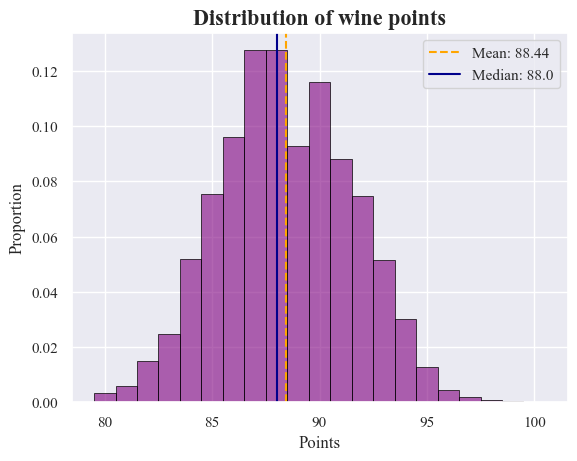

skewness:  0.04357867127543892
kurtosis:  -0.3375368095832032


In [15]:
# Points appear to be normally distributed
# scaling points according to z-score

sns.set_style("darkgrid")
sns.set(font='Times New Roman', font_scale=1)

sns.histplot(wine_df["points"], stat="proportion", discrete=True, color="purple",
            alpha=0.6, edgecolor="black", linewidth=0.5)

plt.title("Distribution of wine points", fontdict=fontdict_title)
plt.xlabel("Points")
sns.set(font='Times New Roman', font_scale=1)

meanval = wine_df["points"].mean()
medianval = wine_df["points"].median()
skewness = wine_df["points"].skew()
kurtosis = wine_df["points"].kurtosis()

plt.axvline(meanval, color="orange", linestyle="--", 
           label="Mean: {:.2f}".format(meanval))
plt.axvline(medianval, color="darkblue", label="Median: {}".format(medianval))


plt.legend()

plt.show()


#plt.savefig("Distribution_wine_plots.png")

print("skewness: ", skewness)
print("kurtosis: ",kurtosis)

According to mean, median, kurtosis and skewness values the distribution of points is approximately normal.

In order to give more credit to wine bottles above average and less credit to those below average we will apply z-score weighting to the proportion weighted scores.

In [16]:
# using sklearn standard scaler and appending z-score weight to data frame

scaler = StandardScaler()
wine_df["point_zscore"] = scaler.fit_transform(np.array(wine_df["points"]).reshape(-1,1))
wine_df["points x proportion x zscore"] = wine_df["points x proportion"]*wine_df["point_zscore"]

In [17]:
# appending z score weighted point sum to winery dataset

zscore_points = wine_df.groupby(by="winery")["points x proportion x zscore"].sum().sort_values(ascending=False)
zscore_points = zscore_points.reset_index()

score_df = score_df.merge(zscore_points, how="left", on="winery")

In [ ]:
# applying min max scaling toz score column for enhanced readability

mmscaler = MinMaxScaler()
score_df["points x proportion x zscore"] = mmscaler.fit_transform(np.array(score_df["points x proportion x zscore"]).reshape(-1,1))

In [150]:
# The vineyard that produces the best wine.

print(score_df.sort_values(by="points x proportion x zscore", ascending=False).head(1))

            winery  points x proportion  count    points  \
1  Williams Selyem             32.18627    204  92.77451   

   points x proportion x zscore  
1                           1.0  


In [27]:
# Exporting to excel to add to presentation

#score_df.sort_values(by="points", ascending=False).head(5).to_excel('points-count.xlsx', index=False, engine='openpyxl')
#score_df.sort_values(by="points x proportion", ascending=False).head(5).to_excel('pointsxprop-count.xlsx', index=False, engine='openpyxl')
#score_df.sort_values(by="points x proportion x zscore", ascending=False).head(5).to_excel('pointsxpropxnorm-count.xlsx', index=False, engine='openpyxl')

**A plot to understand winery likelihood**

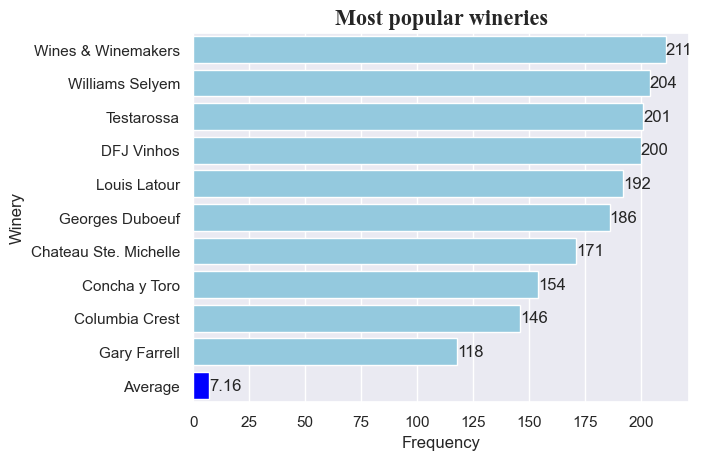

In [19]:
sns.set(font='Times New Roman', font_scale=1)
sns.set_style("darkgrid")
#plt.figure(figsize=(12,7))

winery_counts = score_df.sort_values(by="points x proportion", ascending=False).head(10)

average_winery = pd.DataFrame({
    "winery":["Average"], 
    "points x proportion": [np.nan],
    "count": [np.around(score_df["count"].mean(),2)],
    "points": [score_df["points"].mean()],
    "points x proportion x zscore": [np.nan]}) 

winery_counts = pd.concat([winery_counts, average_winery])

winery_counts

wc = sns.barplot(data=winery_counts, y="winery", x="count", color="skyblue")
wc.bar_label(wc.containers[0])
wc.patches[-1].set_facecolor("blue")


plt.title("Most popular wineries", fontdict=fontdict_title)
plt.xlabel("Frequency")
plt.ylabel("Winery")
plt.show()


#plt.savefig("popular_wineries.png", bbox_inches = "tight")



### Question 2: If you had to pick 3 wines to recommend using only this data, which would you pick?

In [22]:
# Subsetting data for plot to not include outliers

inlier = wine_df[wine_df["price"] < 200]

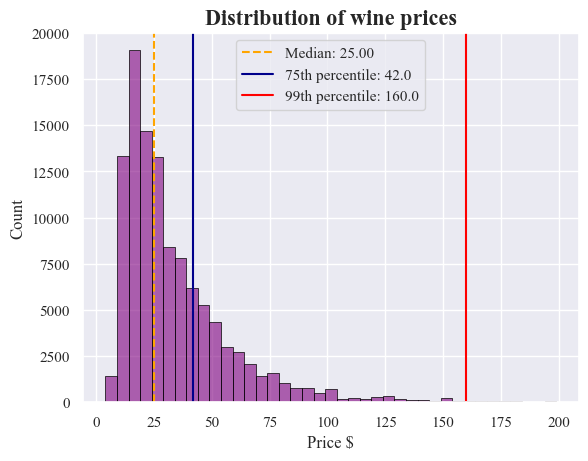

In [71]:
sns.set_style("darkgrid")
sns.set(font='Times New Roman', font_scale=1)

sns.histplot(inlier["price"], binwidth=5, color="purple",
            alpha=0.6, edgecolor="black", linewidth=0.5)

plt.title("Distribution of wine prices", fontdict=fontdict_title)
plt.xlabel("Price $")



medianval = wine_df["price"].median()
perc75 = wine_df["price"].quantile(0.75)
perc99 = wine_df["price"].quantile(0.99)

plt.axvline(medianval, color="orange", linestyle="--", 
           label="Median: {:.2f}".format(medianval))
plt.axvline(perc75, color="darkblue", label="75th percentile: {}".format(perc75))
plt.axvline(perc99, color="red", label="99th percentile: {}".format(perc99))

plt.legend()
plt.show()



#plt.savefig("Wine_price_dist.png", bbox_inches = "tight")

We can see that price follows a left-skewed distribution (more lower-priced wines). Therefore the median and percentiles will provide a more robust way of segregating wine by price.

### Recomending 3 bottles of wine

- separate into 3 price ranges
 - mid_end: upto the median price.
 - high_end: between the median and the 75th percentile.
 - ultra_end: between the 75th percentile and the 99th percentile.

In [24]:
medianval = wine_df["price"].median()
perc25 = wine_df["price"].quantile(0.25)
perc75 = wine_df["price"].quantile(0.75)
perc99 = wine_df["price"].quantile(0.99)

print("25th price percentile: {} \n".format(wine_df["price"].quantile(0.25)))
print("75th price percentile: {} \n".format(wine_df["price"].quantile(0.75)))
print("99th price percentile: {} \n".format(wine_df["price"].quantile(0.99)))

mid_end = wine_df[wine_df["price"] <= medianval]
high_end = wine_df[(wine_df["price"] >= medianval) & (wine_df["price"] <= perc75)]
ultra_end = wine_df[(wine_df["price"] >= perc75) & (wine_df["price"] <= perc99)]

25th price percentile: 17.0 

75th price percentile: 42.0 

99th price percentile: 160.0 



In [153]:
# mid end recommendation

print(mid_end.sort_values(by="points", ascending=False).head(1))

        wine_id country                                        description  \
110026   101580      US  Superb fruit highlights this tight, sculpted S...   

       designation  points  price    province              region_1  \
110026         NaN      96   20.0  Washington  Columbia Valley (WA)   

               region_2   taster_name taster_twitter_handle  \
110026  Columbia Valley  Paul Gregutt          @paulgwineÂ    

                                         title variety winery  proportion  \
110026  Rulo 2007 Syrah (Columbia Valley (WA))   Syrah   Rulo    0.000092   

        points x proportion  point_zscore  points x proportion x zscore  
110026             0.008803      2.443583                      0.021512  


In [154]:
# high end recommendation

print(high_end.sort_values(by="points", ascending=False).head(1))

        wine_id country                                        description  \
106495   114981      US  A seriously top of the heap California Syrah. ...   

               designation  points  price    province   region_1  \
106495  Fenaughty Vineyard      97   35.0  California  El Dorado   

                region_2     taster_name taster_twitter_handle  \
106495  Sierra Foothills  Virginie Boone               @vboone   

                                                    title variety  \
106495  Donkey & Goat 2010 Fenaughty Vineyard Syrah (E...   Syrah   

               winery  proportion  points x proportion  point_zscore  \
106495  Donkey & Goat    0.000417             0.040432      2.766905   

        points x proportion x zscore  
106495                      0.111871  


In [155]:
# Ultra end recomendation

print(ultra_end.sort_values(by="points", ascending=False).head(1))

       wine_id country                                        description  \
66366   123545      US  Initially a rather subdued Frog; as if it has ...   

       designation  points  price    province                 region_1  \
66366  Bionic Frog     100   80.0  Washington  Walla Walla Valley (WA)   

              region_2   taster_name taster_twitter_handle  \
66366  Columbia Valley  Paul Gregutt          @paulgwineÂ    

                                                   title variety  winery  \
66366  Cayuse 2008 Bionic Frog Syrah (Walla Walla Val...   Syrah  Cayuse   

       proportion  points x proportion  point_zscore  \
66366    0.000625             0.062523      3.736869   

       points x proportion x zscore  
66366                      0.233642  


Question 3

Which of the factors (price, country, variety, taster) are most important in determining the overall score of a wine?

In [30]:
# subsetting data set based on variables of interest
factors_df = wine_df[["price", "country", "variety", "taster_name", "points"]]

Dealing with Missing Values

In [31]:
factors_df.isna().sum()

price           8391
country           59
variety            1
taster_name    24912
points             0
dtype: int64

In [46]:
# not possible to replace missing names with twitter handles

wine_df[wine_df["taster_name"].isna() & wine_df["taster_twitter_handle"].notna()]

,wine_id,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,proportion,points x proportion,point_zscore,points x proportion x zscore


### Dealing with missing values

price:
- Due to skewed distribution, impute with median.

country:
- country has 63 missing values, these could be searched through the internet. But due to small number of missing values and short time frame, it would be best to drop.

variety:
- has one missing value. Also better to drop.

taster name:
- those that are missing a name, are missing a twitter handle. missing values will be coded as " ".

In [32]:
# imputing price with median.
factors_df["price"] = factors_df["price"].fillna(factors_df["price"].median())

C:\Users\elena.sinclair\AppData\Local\Temp\ipykernel_12956\877697530.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factors_df["price"] = factors_df["price"].fillna(factors_df["price"].median())


In [33]:
factors_df = factors_df[factors_df["country"].notna() & factors_df["variety"].notna()]

In [34]:
factors_df["taster_name"] = factors_df["taster_name"].fillna(value="")

In [35]:
factors_df.isna().sum()

price          0
country        0
variety        0
taster_name    0
points         0
dtype: int64

Visualising predictors

In [36]:
text = list(factors_df["variety"])
text = " ".join(text)

len(factors_df["variety"].unique())

701

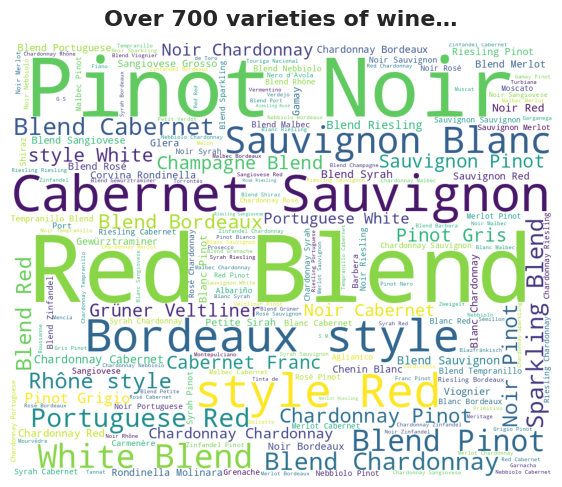

In [38]:
# Creating a wordcloud on wine varieties

wordcloud = WordCloud(width=1000, height=800, background_color='white').generate(text)

plt.figure(figsize=(7, 7))
plt.axis("off")
plt.imshow(wordcloud)
plt.title("Over 700 varieties of wine…", fontdict=fontdict_title, y=1.02)
#plt.savefig("varieties_wordcloud.png")

In [37]:
# A heatmap of points by taster

points_by_taster = factors_df.pivot_table(index="taster_name", columns="points", aggfunc="size", fill_value=0)
points_by_taster = np.log(points_by_taster + 1)

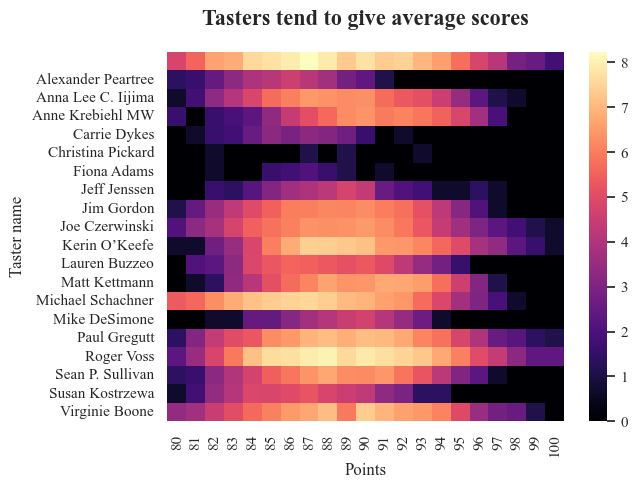

In [73]:
sns.set(font='Times New Roman', font_scale=1)

sns.heatmap(points_by_taster, cmap='magma')
plt.title("Tasters tend to give average scores", 
          fontdict = fontdict_title,
         y=1.05)
plt.xlabel("Points")
plt.ylabel("Taster name")
plt.show()

#plt.savefig("WineScoreTasterHeatmap.png", bbox_inches = "tight")

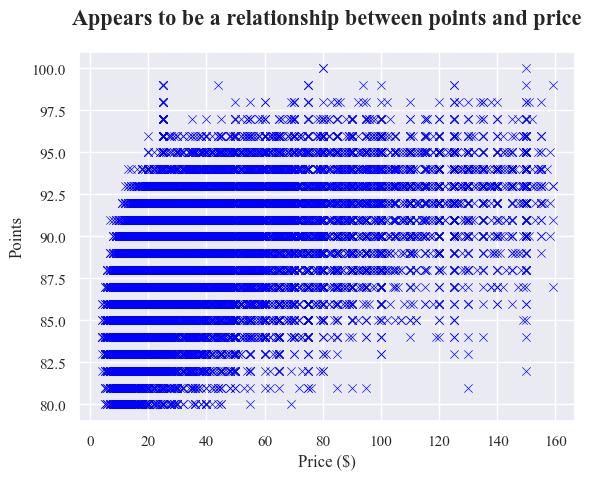

In [74]:
# Exploring the relationship between points and price

sns.set(font='Times New Roman', font_scale=1)

p99factors_df = factors_df[factors_df["price"]<perc99]

sns.scatterplot(data=p99factors_df, x="price", y="points", marker="x",
               color="blue")
plt.title("Appears to be a relationship between points and price", fontdict=fontdict_title,
          y=1.05)
plt.xlabel("Price ($)")
plt.ylabel("Points")

plt.savefig("PointsOnPriceSP.png", bbox_inches = "tight")


Text(0.5, 1.0, 'Most represented countries')

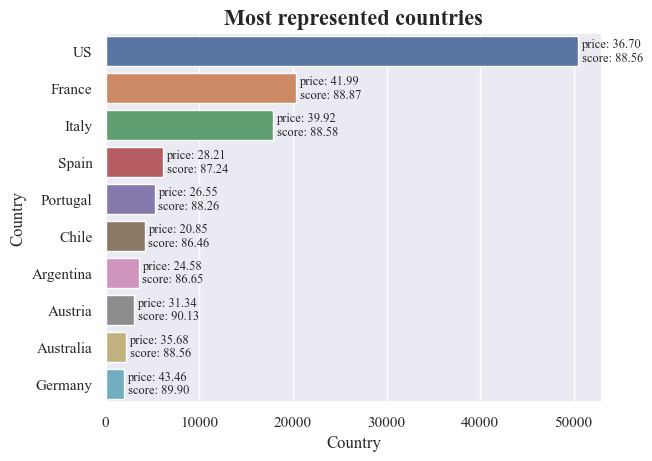

In [134]:
# A countries barplot

countries_df = wine_df.groupby("country").agg({"wine_id":"count",
                                                "points": "mean",
                                                "price":"mean"})

countries_df = countries_df.rename(columns={"wine_id":"count"}).reset_index()

countries_df = countries_df.sort_values(by="count", ascending=False).head(10)

countries_plot = sns.barplot(countries_df, x="count", y="country")


for bar, row in zip(countries_plot.patches, countries_df.iterrows()):
    index, data = row
    label_string = "price: {:.2f}\n score: {:.2f}".format(data['price'], data['points'] )
    countries_plot.text(bar.get_width() + bar.get_x() + 3500, bar.get_y() + bar.get_height() / 2, label_string,
                        ha='center', va='center', fontsize=9)
    
plt.xlabel("Country")
plt.ylabel("Country")
plt.title("Most represented countries", fontdict=fontdict_title)



In [40]:
# Checking number of unique values

for i in wine_df.columns:
    print(i, len(wine_df[i].unique()))

wine_id 119955
country 44
description 119955
designation 37973
points 21
price 391
province 426
region_1 1230
region_2 18
taster_name 20
taster_twitter_handle 16
title 118807
variety 708
winery 16756
proportion 114
points x proportion 1677
point_zscore 21
points x proportion x zscore 1876


In [41]:
# one_hot encoding categorical

factors_df_onehot = pd.get_dummies(factors_df, dtype="int64", drop_first=True)

In [42]:
# seperating predictors and outcomes

onehot_predictors = factors_df_onehot.drop(columns="points", axis=1)
onehot_outcome = factors_df_onehot["points"]

In [44]:
print(onehot_predictors.head())

   price  country_Armenia  country_Australia  country_Austria  \
0   15.0                0                  0                0   
1  100.0                0                  0                0   
2   32.0                0                  0                0   
3  135.0                0                  0                0   
4   17.0                0                  0                1   

   country_Bosnia and Herzegovina  country_Brazil  country_Bulgaria  \
0                               0               0                 0   
1                               0               0                 0   
2                               0               0                 0   
3                               0               0                 0   
4                               0               0                 0   

   country_Canada  country_Chile  country_China  ...  \
0               0              0              0  ...   
1               0              0              0  ...   
2             

In [63]:
# instanciating Linear Regression and Bagging with 10 trees

lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=10, min_samples_split=100, verbose=2)


### Running ML models with 5-fold cross validation

In [65]:
## K fold cross validation

kf = KFold(random_state=1,shuffle=True)

lr_mae_list_train = []
lr_mae_list_test = []
rf_mae_list_train = []
rf_mae_list_test = []

lr_mape_list_train = []
lr_mape_list_test = []
rf_mape_list_train = []
rf_mape_list_test = []

mo_mae_list_train = []
mo_mae_list_test = []
mo_mape_list_train = []
mo_mape_list_test = []

feature_importances = pd.DataFrame({"features":list(onehot_predictors.columns)})


for i, (train_index, test_index) in enumerate(kf.split(onehot_predictors)):
    x_train, x_test = onehot_predictors.iloc[train_index],onehot_predictors.iloc[test_index]
    y_train, y_test = onehot_outcome.iloc[train_index],onehot_outcome.iloc[test_index]
    
    # Linear Regression
    lr.fit(x_train,y_train)
    lr_pred_train = lr.predict(x_train)
    lr_pred_test = lr.predict(x_test)
    
    lr_mae_test = mean_absolute_error(y_test, lr_pred_test)
    lr_mae_train = mean_absolute_error(y_train, lr_pred_train)    
    lr_mape_test = mean_absolute_percentage_error(y_test, lr_pred_test)
    lr_mape_train = mean_absolute_percentage_error(y_train, lr_pred_train)
    
    lr_mae_list_train.append(lr_mae_train)
    lr_mae_list_test.append(lr_mae_test)
    lr_mape_list_train.append(lr_mape_train)
    lr_mape_list_test.append(lr_mape_test)
    
    #Random Forest
    rf.fit(x_train, y_train)
    rf_pred_train = rf.predict(x_train)
    rf_pred_test = rf.predict(x_test)
    
    rf_mae_test = mean_absolute_error(y_test, rf_pred_test)
    rf_mae_train = mean_absolute_error(y_train, rf_pred_train)
    rf_mape_test = mean_absolute_percentage_error(y_test, rf_pred_test)
    rf_mape_train = mean_absolute_percentage_error(y_train, rf_pred_train)
    
    
    rf_mae_list_train.append(rf_mae_train)
    rf_mae_list_test.append(rf_mae_test)
    rf_mape_list_train.append(rf_mape_train)
    rf_mape_list_test.append(rf_mape_test)
    
    # Mean only model
    
    
    mo_pred_train = [y_train.mean() for i in range(len(x_train))]
    mo_pred_test = [y_train.mean() for i in range(len(x_test))]
    
    mo_mae_test = mean_absolute_error(y_test, mo_pred_test)
    mo_mae_train = mean_absolute_error(y_train, mo_pred_train)
    mo_mape_test = mean_absolute_percentage_error(y_test, mo_pred_test)
    mo_mape_train = mean_absolute_percentage_error(y_train, mo_pred_train)
    
    
    mo_mae_list_train.append(mo_mae_train)
    mo_mae_list_test.append(mo_mae_test)
    mo_mape_list_train.append(mo_mape_train)
    mo_mape_list_test.append(mo_mape_test)
    
    
    #Feature importances
    feature_importances["fold: {}".format(i+1)] = rf.feature_importances_
    
    print("{} out of 5 folds complete".format(i+1))
    

    
    
    
    
    
    
    

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
1 out of 5 folds complete
building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
2 out of 5 folds complete
building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
3 out of 5 folds complete
building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
4 out of 5 folds complete
building tre

In [79]:
# Metrics averaged

print(np.mean(rf_mae_list_test))
print(np.mean(rf_mape_list_test))
print(np.mean(mo_mae_list_test))
print(np.mean(mo_mape_list_test))
print(np.mean(lr_mae_list_test))
print(np.mean(lr_mape_list_test))

1.789405125974571
0.020298417209710644
2.535690123968082
0.028712944256838107
3186728.731756424
37057.01873453702


In [61]:
# Averaging feature importance scores over 5 folds

feature_importances["Average"] = feature_importances.iloc[:, 1:].mean(axis=1)

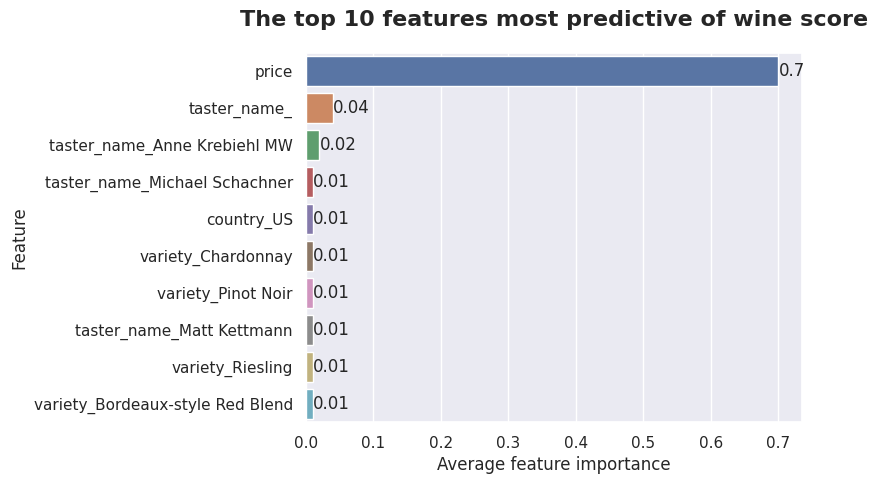

In [89]:
# Feature Importance plot

sns.set(font='Times New Roman', font_scale=1)
sns.set_style("darkgrid")

fidata = feature_importances.sort_values(by="Average", ascending=False).head(10)
fidata["Average"] = np.around(fidata["Average"],2)

fi = sns.barplot(data=fidata, y="features", x="Average")
fi.bar_label(fi.containers[0])

plt.title("The top 10 features most predictive of wine score", 
          fontdict=fontdict_title,
         y=1.05)
plt.xlabel("Average feature importance")
plt.ylabel("Feature")

plt.savefig("FeatureImportance.png", bbox_inches = "tight")

In [157]:
fidata["Average"] = np.around(fidata["Average"],2)

NameError: name 'feature_importances' is not defined

In [156]:
fidata["features"]

NameError: name 'fidata' is not defined

In [ ]:
# Plotting a correlation matrix against points and important features

corr_index = list(fidata.features.values)
corr_index.append("points")

corr_df = factors_df_onehot[corr_index].corr()[["points"]]
corr_df = corr_df.drop(corr_df.index[-1])

plt.figure(figsize=(2,6))
sns.heatmap(corr_df,annot=True)
plt.yticks([])
plt.xticks([])
plt.show()

#plt.savefig("featureimportancecorr.png", bbox_inches = "tight")

### Question 4

**Pre-processing**

In [45]:
# lower case

wine_df["description"] = wine_df["description"].apply(lambda x: x.lower())

def punc_rem(text):
    translator = text.maketrans("","",string.punctuation)
    return text.translate(translator)

# removing punctuation

wine_df["description"] = wine_df["description"].apply(lambda x: punc_rem(x))
    
# remove whitespace from text

def remove_whitespace(text):
    return  " ".join(text.split())

wine_df["description"] = wine_df["description"].apply(lambda x: remove_whitespace(x))



In [49]:
# Removing stopwords

nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words("english"))

def stop_remover(text):
    tokenized_text = word_tokenize(text)
    refined_text = [i for i in tokenized_text if i not in stop_words]
    return refined_text

wine_df["description"] = wine_df["description"].apply(lambda x:stop_remover(x))
    

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elena.sinclair\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\elena.sinclair\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [50]:
# Stemming
stemmer = PorterStemmer()

def stem_words(text):
    stems = [stemmer.stem(i) for i in text]
    return stems

wine_df["description"] = wine_df["description"].apply(lambda x:stem_words(x))



In [51]:
print(stemmer.stem("citrus"))
print(stemmer.stem("dry"))

citru
dri


**Basic word counts for exploratory purpouses**

In [52]:
wine_words_bag = list(wine_df["description"].explode())

In [53]:
wine_words_count = dict(Counter(wine_words_bag))

In [54]:
wine_words_count = pd.DataFrame.from_dict(wine_words_count, orient="index")
wine_words_count = wine_words_count.rename(columns={0:"Count"})

In [55]:
top_words = wine_words_count.sort_values(by="Count", ascending=False)
top_words = top_words.reset_index()
top_words = top_words.rename(columns = {"index":"Word"})

In [57]:
print(top_words.head())

     Word  Count
0    wine  76551
1  flavor  64744
2   fruit  54152
3   aroma  37525
4  finish  37164


<Axes: xlabel='Count', ylabel='Word'>

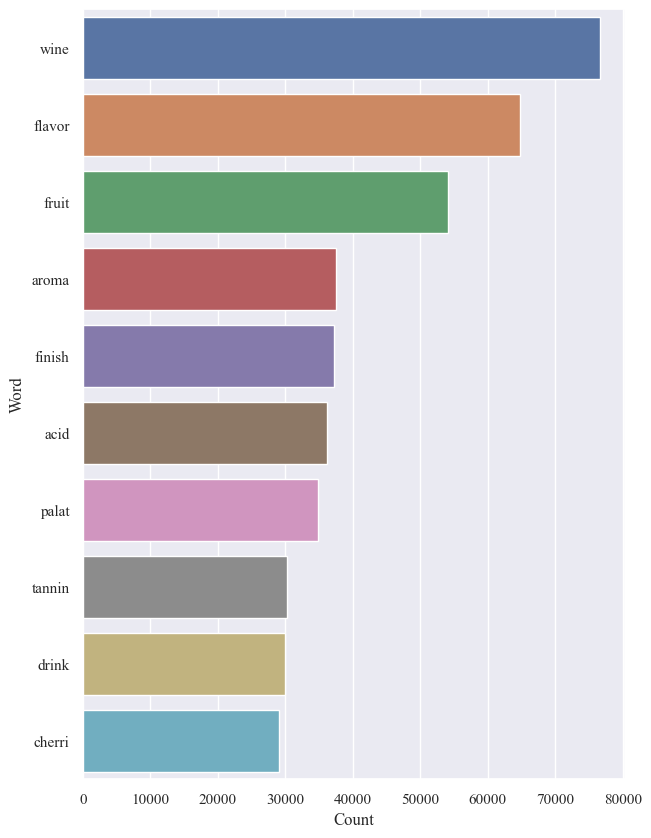

In [159]:
plt.figure(figsize=(7,10))
sns.barplot(data=top_words.head(10), y="Word", x="Count")

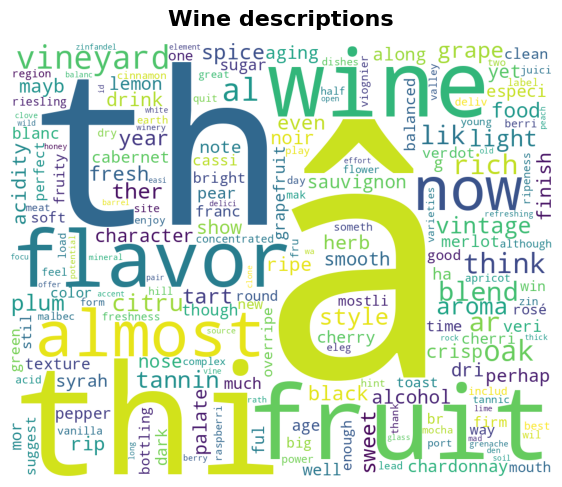

In [19]:
# Description wordcloud.
text = " ".join(list(top_words["Word"]))

wordcloud = WordCloud(width=1000, height=800, background_color='white').generate(text)
plt.figure(figsize=(7, 7))
plt.axis("off")
plt.imshow(wordcloud)
plt.title("Wine descriptions", fontdict=fontdict_title, y=1.02)
plt.savefig("descriptions_wordcloud.png")

In [59]:
# Searching for descriptions that match the key words

relevant_indices = []

for index, row in enumerate(wine_df["description"]):
    if "citru" in row and "dri" in row:
        relevant_indices.append(index)
    

In [60]:
len(relevant_indices)

1571

In [61]:
citrus_dry = wine_df.iloc[relevant_indices].sort_values(by="points", ascending=False)


In [160]:
citrus_dry_1 = citrus_dry.groupby("variety").agg({"wine_id":"count",
                                                 "points":"mean",
                                                 "points x proportion x zscore":"sum"})

print(citrus_dry_1.sort_values(by="points x proportion x zscore", ascending=False).head())

                 wine_id     points  points x proportion x zscore
variety                                                          
Riesling             306  90.431373                      5.588291
Pinot Noir            39  88.538462                      0.918856
Chardonnay           152  88.368421                      0.813182
Pinot Gris            51  89.019608                      0.613577
Champagne Blend       66  90.378788                      0.580485


In [64]:
citrus_dry_1 = pd.DataFrame(citrus_dry_1).reset_index()

Are points still normally distributed? is z-score weigting still appropriate to use?

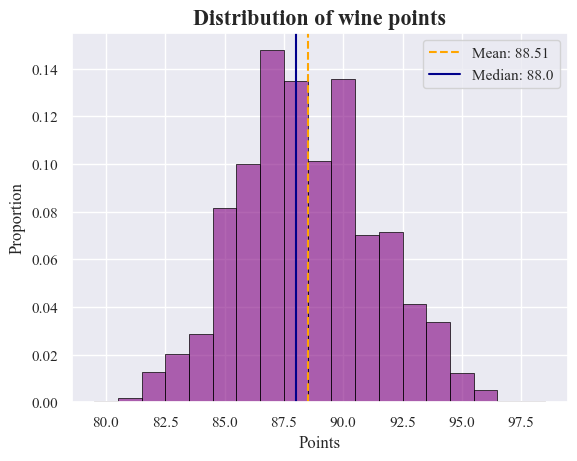

skewness:  0.1627673069933912
kurtosis:  -0.2620001001363703


In [68]:
sns.set_style("darkgrid")
sns.set(font='Times New Roman', font_scale=1)

sns.histplot(citrus_dry["points"], stat="proportion", discrete=True, color="purple",
            alpha=0.6, edgecolor="black", linewidth=0.5)

plt.title("Distribution of wine points", fontdict=fontdict_title)
plt.xlabel("Points")
sns.set(font='Times New Roman', font_scale=1)

meanval = citrus_dry["points"].mean()
medianval = citrus_dry["points"].median()
skewness = citrus_dry["points"].skew()
kurtosis = citrus_dry["points"].kurtosis()

plt.axvline(meanval, color="orange", linestyle="--", 
           label="Mean: {:.2f}".format(meanval))
plt.axvline(medianval, color="darkblue", label="Median: {}".format(medianval))




plt.legend()

plt.show()

print("skewness: ", skewness)
print("kurtosis: ", kurtosis)

#plt.savefig("Distribution_citrus_dry_plot.png")




In [69]:
citrus_dry_1 = citrus_dry_1.rename(columns={"wine_id": "count"})

In [147]:
# applying min max scaling toz score column for enhanced readability

mmscaler = MinMaxScaler()
citrus_dry_1["points x proportion x zscore"] = mmscaler.fit_transform(np.array(citrus_dry_1["points x proportion x zscore"]).reshape(-1,1))

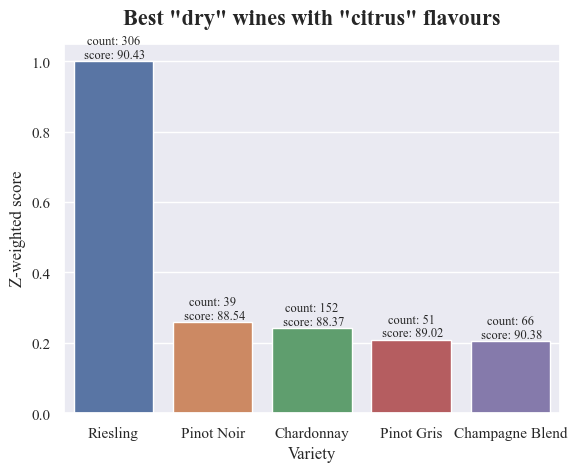

In [148]:
citrus_dry_z = citrus_dry_1.sort_values("points x proportion x zscore", ascending=False).head()

z_plot = sns.barplot(citrus_dry_z, x="variety", y= "points x proportion x zscore")

ax = plt.gca()

for bar, row in zip(ax.patches, citrus_dry_z.iterrows()):
    index, data = row
    label_string = "count: {}\n score: {:.2f}".format(data['count'], data['points'] )
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), label_string,
            ha='center', va='bottom', fontsize=9)

plt.xlabel("Variety")
plt.ylabel("Z-weighted score")
plt.title('Best "dry" wines with "citrus" flavours', fontdict=fontdict_title, y = 1.03)

plt.show()